## Books Dataset

### 1. Book Recommendation
- Using TD-IDF

### 2. Predicting Book Ratings
- Multilayer Perceptron using Keras

#### Libraries Used

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import pandas as pd


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from scipy import sparse

## Book Recommendations

#### 1. Load and Explore Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

#load data
df0 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cluster_0 copy.csv')
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cluster_1 copy.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cluster_2 copy.csv')
df0['cluster'] = 0
df1['cluster'] = 1
df2['cluster'] = 2
df = pd.concat([df0, df1, df2], ignore_index=True)


print(df.shape)
df.head(3)

Mounted at /content/drive
(28644, 36)


,bookId,title,series,author,rating,description,language,isbn,genres,characters,...,year,has_award,ratings_list,rating_5star,rating_4star,rating_3star,rating_2star,rating_1star,popularityRatio,cluster
0,1953.A_Tale_of_Two_Cities,A Tale of Two Cities,NaN,"Charles Dickens, Richard Maxwell (Editor/Intro...",3.85,After eighteen years as a political prisoner i...,English,9780141439600,"['Classics', 'Fiction', 'Historical Fiction', ...","['Sydney Carton', 'Charles Darnay', 'Lucie Man...",...,2003.0,0,"[277631, 259424, 176879, 63052, 33014]",277631.0,259424.0,176879.0,63052.0,33014.0,91.127679,0
1,168668.Catch_22,Catch-22,Catch-22 #1,Joseph Heller,3.98,"The novel is set during World War II, from 194...",English,9780684833392,"['Classics', 'Fiction', 'War', 'Historical Fic...","['Yossarian', 'Chaplain Tappman', 'Milo Minder...",...,2004.0,1,"[289501, 230048, 130390, 47160, 26048]",289501.0,230048.0,130390.0,47160.0,26048.0,91.656040,0
2,2623.Great_Expectations,Great Expectations,NaN,"Charles Dickens, Παυλίνα Παμπούδη (Translator)...",3.78,"'In what may be Dickens's best novel, humble, ...",English,9780192833594,"['Classics', 'Fiction', 'Literature', 'Histori...","['Miss Havisham', 'Philip ""Pip"" Pirrip', 'Jose...",...,1998.0,1,"[200286, 218262, 149650, 54551, 28757]",200286.0,218262.0,149650.0,54551.0,28757.0,86.958343,0


In [5]:
df['pages'] = pd.to_numeric(df['pages'], errors='coerce')
df['rating'] = df['rating'].replace('No rating', np.nan)
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['year'] = pd.to_numeric(df['year'], errors='coerce')

df_cleaned = df.drop(columns=['language', 'awards']) # drop unecessary columns

df = df_cleaned

median_year = df['year'].median()
df['year'].fillna(median_year, inplace=True)

df_cleaned = df
df_cleaned.head(5)

/tmp/ipython-input-2891050719.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['year'].fillna(median_year, inplace=True)


,bookId,title,series,author,rating,description,isbn,genres,characters,bookFormat,...,year,has_award,ratings_list,rating_5star,rating_4star,rating_3star,rating_2star,rating_1star,popularityRatio,cluster
0,1953.A_Tale_of_Two_Cities,A Tale of Two Cities,NaN,"Charles Dickens, Richard Maxwell (Editor/Intro...",3.85,After eighteen years as a political prisoner i...,9780141439600,"['Classics', 'Fiction', 'Historical Fiction', ...","['Sydney Carton', 'Charles Darnay', 'Lucie Man...",Paperback,...,2003.0,0,"[277631, 259424, 176879, 63052, 33014]",277631.0,259424.0,176879.0,63052.0,33014.0,91.127679,0
1,168668.Catch_22,Catch-22,Catch-22 #1,Joseph Heller,3.98,"The novel is set during World War II, from 194...",9780684833392,"['Classics', 'Fiction', 'War', 'Historical Fic...","['Yossarian', 'Chaplain Tappman', 'Milo Minder...",Paperback,...,2004.0,1,"[289501, 230048, 130390, 47160, 26048]",289501.0,230048.0,130390.0,47160.0,26048.0,91.656040,0
2,2623.Great_Expectations,Great Expectations,NaN,"Charles Dickens, Παυλίνα Παμπούδη (Translator)...",3.78,"'In what may be Dickens's best novel, humble, ...",9780192833594,"['Classics', 'Fiction', 'Literature', 'Histori...","['Miss Havisham', 'Philip ""Pip"" Pirrip', 'Jose...",Paperback,...,1998.0,1,"[200286, 218262, 149650, 54551, 28757]",200286.0,218262.0,149650.0,54551.0,28757.0,86.958343,0
3,6288.The_Road,The Road,NaN,Cormac McCarthy,3.97,"A searing, postapocalyptic novel destined to b...",9780307265432,"['Fiction', 'Science Fiction', 'Dystopia', 'Po...","['The man', 'The boy']",Hardcover,...,2006.0,1,"[271747, 245274, 128293, 45727, 25156]",271747.0,245274.0,128293.0,45727.0,25156.0,91.193695,0
4,3836.Don_Quixote,Don Quixote,NaN,"Miguel de Cervantes Saavedra, John Rutherford ...",3.88,Don Quixote has become so entranced by reading...,9780142437230,"['Classics', 'Fiction', 'Literature', 'Spanish...","['Sancho Panza', 'Don Quijote de la Mancha']",Paperback,...,2003.0,1,"[72520, 66539, 48749, 15704, 6176]",72520.0,66539.0,48749.0,15704.0,6176.0,87.737297,0


#### 2. Preprocess the Data

In [6]:
# 清洗文本
df['description'] = df['description'].fillna("")

df['genres'] = df['genres'].fillna("")

# 2. 将 genres 列表转换为单个字符串（以空格分隔）
# 确保只对列表进行 join 操作，非列表对象（如空字符串）直接保留
def list_to_str(genre_list):
    if isinstance(genre_list, list):
        return ' '.join(genre_list)
    return str(genre_list)

df['genres_str'] = df['genres'].apply(list_to_str)

# --- 2. 特征合并 ---

# 将 description 和 genres 文本合并为单个特征列
# 我们在 genres 前面添加一个前缀（例如：'genre'）以提高其权重，但这里为了简单直接拼接
df['combined_features'] = df['description'] + ' ' + df['genres_str']


#### 3. Initialize function: TD-IDF to Recommendation

In [7]:
# --- 3. TF-IDF ---
# vectorise merged_text
# increase max_features to support more genre types
tfidf = TfidfVectorizer(stop_words='english', max_features=10000)
tfidf_matrix = tfidf.fit_transform(df['combined_features'])

# --- 4. calculate similarity ---
# find closest 10 books（use cosine distance）
nn = NearestNeighbors(metric='cosine', algorithm='brute')
nn.fit(tfidf_matrix)

# distances = distance matrix (smaller value = closer)
# indices = index of neighbour
distances, indices = nn.kneighbors(tfidf_matrix, n_neighbors=10)

# --- 5. function of recommendation ---
# title → row index mapping
title_to_idx = pd.Series(df.index, index=df['title']).drop_duplicates()

def recommend_books(title, top_n=5):
    if title not in title_to_idx:
        return f"'{title}' not found in dataset."

    idx = title_to_idx[title]

    # take (idx)th records before top_n (skip itself)
    neighbor_indices = indices[idx][1:top_n+1]

    # return title、author、genres info
    return df[['title', 'author', 'genres']].iloc[neighbor_indices]

In [8]:
def recommend_books(title, top_n=5):
    if title not in title_to_idx:
        return f"'{title}' not found in dataset."

    idx = title_to_idx[title]

    # 取第 idx 本书的邻居（跳过自己）
    neighbor_indices = indices[idx][1:top_n+1]

    return df[['title', 'author', 'genres']].iloc[neighbor_indices]


In [9]:
recommend_books("The Book Thief")

,title,author,genres
27844,Library Mouse,Daniel Kirk,"['Picture Books', 'Childrens', 'Animals', 'Fic..."
5599,The Giraffe and the Pelly and Me,"Roald Dahl, Quentin Blake (Illustrator)","['Childrens', 'Fiction', 'Fantasy', 'Classics'..."
37,Inkheart,"Cornelia Funke (Goodreads Author), Anthea Bell...","['Fantasy', 'Young Adult', 'Fiction', 'Childre..."
22319,My Family for the War,"Anne C. Voorhoeve, Tammi Reichel (Translator)","['Historical Fiction', 'Young Adult', 'World W..."
1727,The Little Paris Bookshop,"Nina George (Goodreads Author), Simon Pare (Tr...","['Fiction', 'Romance', 'Books About Books', 'F..."


In [10]:
recommend_books("The Hunger Games")

,title,author,genres
21640,The Hunger Games Tribute Guide,Emily Seife (Goodreads Author),"['Young Adult', 'Dystopia', 'Fantasy', 'Fictio..."
23601,Guide to The Hunger Games,"Caroline Carpenter, Stephanie Clarkson","['Young Adult', 'Science Fiction', 'Dystopia']"
11459,The Hunger Games Trilogy Boxset,"Suzanne Collins, Guillaume Fournier (Translato...","['Young Adult', 'Fiction', 'Fantasy', 'Dystopi..."
15157,The Quillan Games,D.J. MacHale (Goodreads Author),"['Fantasy', 'Young Adult', 'Science Fiction', ..."
28633,Mockingjay,Suzanne Collins,"['Young Adult', 'Dystopia', 'Fiction', 'Fantas..."


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('title').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('author').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('genres').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['author'].value_counts()
    for x_label, grp in _df_3.groupby('title')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('title')
_ = plt.ylabel('author')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['genres'].value_counts()
    for x_label, grp in _df_4.groupby('author')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('author')
_ = plt.ylabel('genres')

## Predicting Book Ratings

#### 1. Load and Explore Dataset

In [11]:
from google.colab import drive
drive.mount('/content/drive')

#load data
df0 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cluster_0 copy.csv')
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cluster_1 copy.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cluster_2 copy.csv')
df0['cluster'] = 0
df1['cluster'] = 1
df2['cluster'] = 2
df = pd.concat([df0, df1, df2], ignore_index=True)

# Fill missing values
df['description'] = df['description'].fillna("")
df['year'].fillna(df['year'].median(), inplace=True)
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['rating'].fillna(df['rating'].median(), inplace=True)
df['avg_bbeScore'].fillna(df['avg_bbeScore'].median(), inplace=True)

# Create binary target: 1 = "like", 0 = "dislike"
df['liked'] = (df['rating'] >= 4.0).astype(int)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-1730639595.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['year'].fillna(df['year'].median(), inplace=True)
/tmp/ipython-input-1730639595.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

#### 2. Preprocess Data

In [12]:
df.columns

Index(['bookId', 'title', 'series', 'author', 'rating', 'description',
       'language', 'isbn', 'genres', 'characters', 'bookFormat', 'edition',
       'pages', 'publisher', 'publishDate', 'firstPublishDate', 'awards',
       'numRatings', 'ratingsByStars', 'likedPercent', 'setting', 'bbeScore',
       'bbeVotes', 'price', 'id', 'avg_bbeScore', 'year', 'has_award',
       'ratings_list', 'rating_5star', 'rating_4star', 'rating_3star',
       'rating_2star', 'rating_1star', 'popularityRatio', 'cluster', 'liked'],
      dtype='object')

In [13]:
# Text (TF-IDF)
tfidf = TfidfVectorizer(max_features=3000, stop_words='english')
X_text = tfidf.fit_transform(df['description'])

# Numeric features
numeric = df[['likedPercent','avg_bbeScore','year', 'numRatings','price','has_award']].fillna(0)
scaler = StandardScaler()
X_numeric = scaler.fit_transform(numeric)

# 3. Genre -> MultiLabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_lists = df['genres'].str.split('|')
X_genre = mlb.fit_transform(genres_lists)


# 4. 合并所有特征（注意保持 sparse）
X_all = sparse.hstack([
    X_text,
    X_genre,
    sparse.csr_matrix(X_numeric)
])

# 5. Label & 划分
y = df['liked'].values
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, random_state=42
)

#### 3. Build Keras Model

In [14]:
input_dim = X_train.shape[1]

model = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
573/573 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - accuracy: 0.8198 - loss: 0.4351 - val_accuracy: 0.8473 - val_loss: 0.3365
Epoch 2/5
573/573 ━━━━━━━━━━━━━━━━━━━━ 45s 59ms/step - accuracy: 0.9109 - loss: 0.2285 - val_accuracy: 0.8324 - val_loss: 0.3773
Epoch 3/5
573/573 ━━━━━━━━━━━━━━━━━━━━ 30s 52ms/step - accuracy: 0.9748 - loss: 0.0832 - val_accuracy: 0.8141 - val_loss: 0.5100
Epoch 4/5
573/573 ━━━━━━━━━━━━━━━━━━━━ 30s 52ms/step - accuracy: 0.9935 - loss: 0.0259 - val_accuracy: 0.7927 - val_loss: 0.6485
Epoch 5/5
573/573 ━━━━━━━━━━━━━━━━━━━━ 33s 57ms/step - accuracy: 0.9981 - loss: 0.0077 - val_accuracy: 0.7986 - val_loss: 0.7239


#### 4. Test Keras Model

In [15]:
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      2842
           1       0.80      0.78      0.79      2887

    accuracy                           0.79      5729
   macro avg       0.79      0.79      0.79      5729
weighted avg       0.79      0.79      0.79      5729



### Keras Model Performance

180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


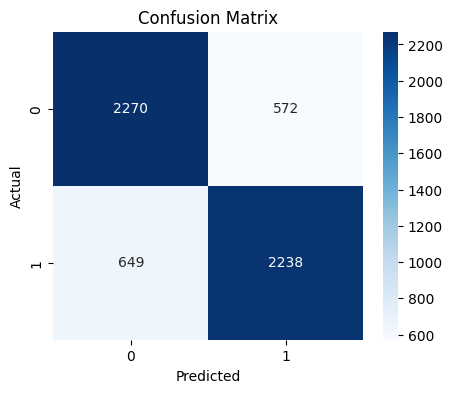

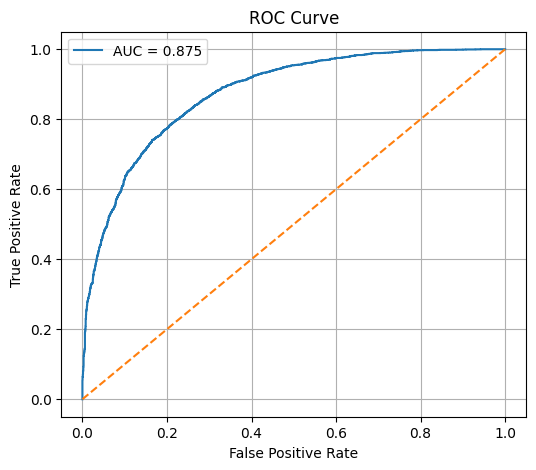

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc,
    precision_recall_curve, f1_score
)
import seaborn as sns
import numpy as np

# ===== 1. 取得概率预测 =====
y_proba = model.predict(X_test).ravel()   # Keras MLP 输出
y_pred = (y_proba > 0.5).astype(int)

# ===== 2. 混淆矩阵 =====
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# ===== 3. ROC 曲线 =====
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
